In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astroquery.ned import Ned
from astropy import coordinates
import astropy.units as u
from datetime import datetime
from astropy.time import Time

In [3]:
#query tns recent classified Ia
from tnsScrape import getTNS
queryres = getTNS(discoverdays=10,reportdays="",classified=True,skip_ztf=False,num_page=500,verbose=True)
queryres

https://wis-tns.weizmann.ac.il/search?discovered_period_value=&discovered_period_units=days&date_start%5Bdate%5D=2020-04-03&date_end%5Bdate%5D=2020-04-13&classified_sne=1&unclassified_at=0&discovery_mag_min=16&discovery_mag_max=21&num_page=500&objtype=3&redshift_min=0.015&redshift_max=0.08&sort=desc&order=discoverydate
Number of tables on the webpage: 8
Number of rows in search result:  1


,internal_name,redshift,ra_s,dec_s,hostname,host_redshift,discoverydate,discoverymag,disc_filter_name,tns_name,type,meanra,meandec,oid
0,ZTF20aauowam,0.064,15:34:33.043,+37:32:01.82,WISEA J153433.10+373155.6,0.064391,2020-04-04 11:00:17.001,20.1138,g-ZTF,2020fxa,SN Ia,233.637679,37.533839,2020fxa


In [4]:
def query_ned(ra,dec):
    co = coordinates.SkyCoord(ra=ra, dec=dec, unit=(u.deg, u.deg), frame='fk5')
    Ned_table = Ned.query_region(co, radius=0.02 * u.deg, equinox='J2000.0')
    Ned_table['Type'] = Ned_table['Type'].astype(str)
    if 'G' in Ned_table['Type'].astype(str):
        res = Ned_table[Ned_table['Type'] == 'G']
    else:
        res = None
    return res 

In [5]:
# query oid
def query_oid(oid,z,zerr,source):
    if source == 'ztf':
        from broker_query import Alerce
        alerce = Alerce()
        alerce.setup()
        query = '''
                select objects.oid, objects.nobs, objects.meanra, objects.meandec, objects.firstmjd, objects.lastmjd,
                objects.first_magpsf_g, objects.first_magpsf_r, objects.last_magpsf_g, objects.last_magpsf_r, objects.classearly
                from objects 
                where objects.oid = '{}'
                '''.format(oid)
        alerce.load_query(query)
        alerce.make_query()
        target = alerce.queryresult

    if source == 'tns':
        from tnsScrape import get_tns_data
        target = get_tns_data(oid)['meta']
        target['meanra'] = target['radeg']
        target['meandec'] = target['decdeg']
        target['oid'] = oid

    if z is None:
        host = query_ned(target['meanra'],target['meandec']).to_pandas().dropna().sort_values('Separation',ascending=True).reset_index(drop=True)
        display(host[['Object Name','RA','DEC','Redshift','Separation']])
        z = host['Redshift'][0]
    target['z'] = z
    target['zerr'] = zerr
#     display(target)
    return target

In [6]:
targets = pd.DataFrame() 
for i,row in queryres.iterrows():
    if row['internal_name'].startswith('ZTF'):
        source = 'ztf'
        oid = row['internal_name']
    else:
        source = 'tns'
        oid = row['tns_name']
    z = float(row['redshift'])
    zerr = 0.001
#     print(oid,z)
    target = query_oid(oid,z,zerr,source)
    if source == 'tns':
        target['nobs'] = -99
        target['gmaglatest'] = target['discoverymag'].astype(float)
        target['rmaglatest'] = target['gmaglatest']
        target['lastmjd'] = Time(list(target['discoverydate'].values),format='iso').mjd
        target['Broker'] = 'tns'
    else:
        target['Broker'] = 'alerce'
    target['source'] = source
    targets = pd.concat([targets,target],sort=False,ignore_index=True)
targets

queryresult size: 1


,oid,nobs,meanra,meandec,firstmjd,lastmjd,first_magpsf_g,first_magpsf_r,last_magpsf_g,last_magpsf_r,classearly,z,zerr,Broker,source
0,ZTF20aauowam,4,233.637653,37.533827,58943.45853,58944.506065,20.1138,20.287695,19.663385,19.698132,19,0.064,0.001,alerce,ztf


ZTF20aauowam: z=0.0640 +/- 0.0010
ra = 15:34:33.037 dec = +37:32:01.78 mwebv=0.014


/home/mi/anaconda3/lib/python3.7/site-packages/sncosmo/models.py:186: RuntimeWarning: invalid value encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)
/home/mi/anaconda3/lib/python3.7/site-packages/sncosmo/models.py:186: RuntimeWarning: invalid value encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)


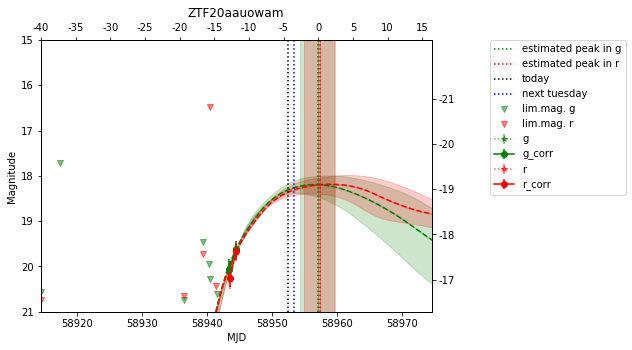

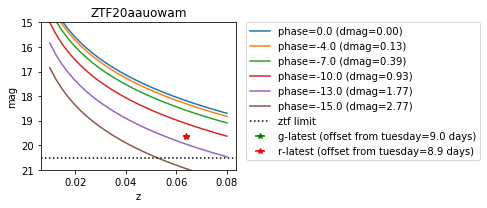

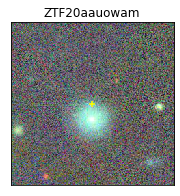

In [7]:
from utils import *
import matplotlib.pyplot as plt
import os
from PyPDF2 import PdfFileMerger
# %matplotlib inline

from astropy.time import Time
from datetime import datetime,date
querydate = datetime.today()

interactive = False
savepdf = False

if savepdf:
    pdf_file = 'data/screenshots/tns_classified/Classified_{}.pdf'.format(querydate.strftime("%m-%d-%Y"))
    folder = 'data/screenshots/tns_classified/{}'.format(querydate.strftime("%m-%d-%Y"))
    if not os.path.isdir(folder):
        os.mkdir(folder)
    pdflist = []
    orderlist = []
# display(target[target.oid=='ZTF20aamfpft'])
for i,row in targets[0:].iterrows():
    if savepdf:
        f = '{}/{}.pdf'.format(folder,row.oid)
    else:
        f = None
    res = gen_plots(row,interactive=interactive,pdf_file=f,magabs=-19.1,extra_lc=False,last_detection_max=10,source=row['source'])
    if not res['too_old'] and savepdf:
        pdflist.append(f) 
        orderlist.append(res['phase_tuesday'])
if savepdf:
    idx_ordered = np.argsort(orderlist)
    merger = PdfFileMerger()
    for pdf in np.array(pdflist)[idx_ordered]:
        merger.append(pdf)
    merger.write(pdf_file)
    merger.close()